**Корректность проверена на Python 3.6:**
+ pandas 0.23.4
+ numpy 1.15.4
+ matplotlib 3.0.2
+ sklearn 0.20.2

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Sklearn

В этой задаче по историческим данным о погодных условиях и аренде велосипедов требуется предсказать, сколько же велосипедов будет занято в заданный день и час. В исходной постановке задачи нам доступно 11 признаков, среди них есть как числовые признаки, так и категориальные, и бинарные данные. 

## Bike Sharing Demand
Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодным условиям необходимо оценить спрос на прокат велосипедов.

В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

Для демонстрации используется обучающая выборка из исходных данных train.csv, файлы для работы прилагаются.

### Библиотеки

In [2]:
from sklearn import model_selection, linear_model, metrics

import numpy as np
import pandas as pd

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [4]:
raw_data = pd.read_csv('bike_sharing_demand.csv', header = 0, sep = ',')

In [5]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***casual*** - number of non-registered user rentals initiated

***registered*** - number of registered user rentals initiated

***count*** - number of total rentals

In [6]:
print(raw_data.shape)

(10886, 12)


Посмотрим, есть ли там пропущенные значения, потому что если они есть, то нам придется задуматься о том, как же их обработать. Делаем это с помощью метода `isnull`

In [11]:
raw_data.isnull().values.any()

False

### Предобработка данных

#### Типы признаков

In [12]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [13]:
# нужно преобразовать столбец в формат datetime 
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [14]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)

In [15]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4


#### Обучение и отложенный тест
Далее для работы нам удобно разделить наши данные на обучение и тест. В этом случае нам удобнее разбить данные по времени. Давайте будем строить модель на данных за более ранний период и оценивать ее качество на данных за более поздний период. В данном случае наши данные отсортированы по времени, поэтому для того чтобы получить такое разбиение, достаточно просто отрезать последний кусок данных, допустим последние 1000 объектов, и отправить их в отложенный dataset. Это мы сделаем с помощью метода `iloc`.


*Почему в задачах, где есть метка времени, лучше разделять выборку на обучение и контроль по ней, а не случайным образом?
Потому что таким образом мы гарантируем, что не будем использовать информацию "из будущего".*

In [16]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [17]:
print(raw_data.shape, train_data.shape, hold_out_test_data.shape)

(10886, 14) (9886, 14) (1000, 14)


In [18]:
print('train period from {} to {}'.format(train_data.datetime.min(), train_data.datetime.max()))
print('evaluation period from {} to {}'.format(hold_out_test_data.datetime.min(), hold_out_test_data.datetime.max()))

train period from 2011-01-01 00:00:00 to 2012-10-16 06:00:00
evaluation period from 2012-10-16 07:00:00 to 2012-12-19 23:00:00


#### Данные и целевая функция

Для работы с моделями в Sklearn нам требуется отделить целевую метку от остальных данных. Давайте сделаем это для обучающей и для тестовой выборки. Мы знаем, что целевая метка находится в столбце count, поэтому давайте вырежем его из остальных данных. И также вырежем столбец datetime, потому что фактически это просто идентификатор объекта. Делаем это на обоих выборках.

In [19]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count'], axis = 1)

In [20]:
#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count'], axis = 1)

#### Целевая функция на обучающей выборке и на отложенном тесте

И теперь давайте визуализируем целевую переменную, посмотрим на ее распределение на обучении и на тесте. Ну вот, мы видим, что распределение отличается, но, в общем-то, можно сказать, что и во время обучения, и во время теста большую часть времени было занято не более 300 велосипедов

Text(0.5, 1.0, 'test data')

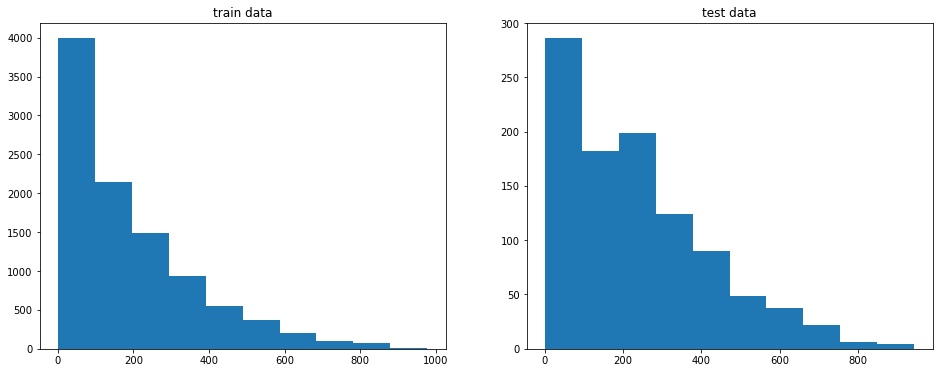

In [21]:
pylab.figure(figsize = (16, 6))

pylab.subplot(1,2,1)
pylab.hist(train_labels)
pylab.title('train data')

pylab.subplot(1,2,2)
pylab.hist(test_labels)
pylab.title('test data')

#### Числовые признаки

В рамках этого урока мы с вами будем работать только с численными признаками, поэтому давайте сначала их отделим — создадим соответствующий список, — и теперь будем работать только с той частью обучающей и тестовой выборки, которая соответствует этим признакам.

In [22]:
numeric_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'month', 'hour']

In [23]:
train_data = train_data[numeric_columns]
test_data = test_data[numeric_columns]

In [24]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0.0,3,13,1,0
1,9.02,13.635,80,0.0,8,32,1,1
2,9.02,13.635,80,0.0,5,27,1,2
3,9.84,14.395,75,0.0,3,10,1,3
4,9.84,14.395,75,0.0,0,1,1,4


In [25]:
test_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
9886,17.22,21.210,67,6.0032,20,505,10,7
9887,18.04,21.970,62,0.0000,35,800,10,8
9888,19.68,23.485,55,16.9979,32,323,10,9
9889,20.50,24.240,48,19.0012,65,157,10,10
9890,20.50,24.240,45,27.9993,56,172,10,11


### Модель

Так как мы решаем задачу регрессии, давайте обучать SGDRegressor — это регрессия на основе стохастического градиентного спуска. Для начала создадим модель с параметрами по умолчанию и попробуем ее обучить на обучающей части данных. Делаем это с помощью метода fit, а дальше сразу давайте оценим качество с помощью метрики mean_absolute_error — средняя ошибка. Оценивать будем на тестовой части данных.

In [26]:
regressor = linear_model.SGDRegressor(random_state = 0, max_iter=5)
regressor.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 5,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': 0,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

мы получили какую-то невероятно большую ошибку. Давайте посмотрим, как выглядят наши предсказания, и сравним их с правильным значением целевой функции. Сначала выведем на экран целевую функцию, теперь — наши предсказания, и мы видим, что мы предсказываем невероятно большие числа. Так быть не должно. Давайте посмотрим на коэффициенты регрессии — может быть это прольет свет на ошибку. Так, мы видим, что у нас невероятно большие коэффициенты. 

In [27]:
regressor.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(test_data))

31851310300813.895

In [28]:
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [29]:
print(regressor.predict(test_data)[:10])

[6.38237236e+13 9.93774167e+13 4.50263651e+13 3.24238509e+13
 3.17252459e+13 4.39305995e+13 4.44982989e+13 4.41783289e+13
 4.68904479e+13 5.83210989e+13]


In [30]:
regressor.coef_

array([ 1.51022653e+11, -5.06697186e+10,  4.53044112e+10, -7.46986340e+10,
        1.80525319e+11,  1.10015690e+11, -3.01811345e+09,  8.39465294e+10])

### Scaling

В данном случае мы работаем с набором данных, в котором признаки могут сильно отличаться по масштабам. Для того чтобы решить эту проблему, нам нужно сначала отмасштабировать признаки в нашем наборе данных. В Sklearn это можно сделать с помощью модуля preprocessing, нам понадобится объект StandardScaler. 

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
StandardScaler?

    StandardScaler?

Standardize features by removing the mean and scaling to unit variance

The standard score of a sample `x` is calculated as:

    z = (x - u) / s

where `u` is the mean of the training samples or zero if `with_mean=False`,
and `s` is the standard deviation of the training samples or one if
`with_std=False`.

Centering and scaling happen independently on each feature by computing
the relevant statistics on the samples in the training set. Mean and
standard deviation are then stored to be used on later data using
:meth:`transform`.

Standardization of a dataset is a common requirement for many
machine learning estimators: they might behave badly if the
individual features do not more or less look like standard normally
distributed data (e.g. Gaussian with 0 mean and unit variance).

For instance many elements used in the objective function of
a learning algorithm (such as the RBF kernel of Support Vector
Machines or the L1 and L2 regularizers of linear models) assume that
all features are centered around 0 and have variance in the same
order. If a feature has a variance that is orders of magnitude larger
that others, it might dominate the objective function and make the
estimator unable to learn from other features correctly as expected.

In [ ]:
#создаем стандартный scaler
scaler = StandardScaler()
scaler.fit(train_data, train_labels)  # Compute the mean and std to be used for later scaling.
scaled_train_data = scaler.transform(train_data)  # Perform standardization by centering and scaling
scaled_test_data = scaler.transform(test_data)

In [ ]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

In [ ]:
print(test_labels[:10])

In [ ]:
print(regressor.predict(scaled_test_data)[:10])

### Подозрительно хорошо?

Ошибка стала очень маленькой. Давайте выведем целевую функцию и наши прогнозы. Видим, что мы ошибаемся меньше, чем на один велосипед. Это очень странно. Давайте посмотрим на коэффициенты регрессии, чтобы понять, что же произошло. В таком виде их не очень удобно анализировать, давайте округлим. И что мы видим? Практически все признаки принимают очень маленькие веса, за исключением двух. 

In [ ]:
print(regressor.coef_)

In [ ]:
print(list(map(lambda x : round(x, 2), regressor.coef_)))

In [ ]:
train_data.head()

In [ ]:
train_labels[:10]

Итак, мы видим, что это признаки casual и registered. Давайте попытаемся вспомнить из описания данных, что они означают. Фактически система аренды велосипедов работает следующим образом: системой может воспользоваться как зарегистрированный пользователь, так и незарегистрированный. В данном случае наши столбцы представляют количество зарегистрированных пользователей, которые используют систему — это столбец registered. И количество пользователей, которые не зарегистрировались, но также хотят арендовать велосипед — это столбец casual. Давайте выведем значения целевой функции и увидим следующую закономерность: фактически, если значение этих двух столбцов сложить, то мы получим нашу целевую метку. 

In [ ]:
np.all(train_data.registered + train_data.casual == train_labels)

Давайте вырежем эти данные из нашего набора данных. Вырежем их как из обучающей, так и из тестовой выборки. Теперь давайте снова отмасштабируем признаки уже на новом наборе данных. И теперь обучим модель и оценим качество.

In [ ]:
train_data.drop(['casual', 'registered'], axis = 1, inplace = True)
test_data.drop(['casual', 'registered'], axis = 1, inplace = True)

In [ ]:
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [ ]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

In [ ]:
print(list(map(lambda x : round(x, 2), regressor.coef_)))

### Pipeline

Модель мы обучали с параметрами по умолчанию, поэтому теперь давайте подберем параметры, оптимальные для решаемой задачи. Подбор параметров мы делаем по кросс-валидации. В данном случае с этим может возникнуть проблема, потому что прежде чем обучать модель, мы хотим делать scaling — мы хотим масштабировать признаки. Однако масштабирование мы обучаем только по обучающей части выборки. Таким образом, при кросс-валидации нам придется обучить сразу несколько скейлеров — по одному на каждую итерацию кросс-валидации. Получается, что нам нужно писать неудобные циклы, и запись будет достаточно громоздкой. Однако Sklearn предоставляет нам способ, для того чтобы этого избежать — такой способ называется Pipeline. Вместо одного преобразования мы с вами можем реализовать целую цепочку преобразований.

В данном случае мы хотим делать два шага: первый шаг — это масштабирование признаков, второй шаг — это непосредственно обучение модели. Вот давайте такой Pipeline и создадим.

Передаем ему параметр steps — это список наших шагов, и далее каждый шаг представляется тьюплом, где первый элемент — это имя шага, второй элемент — это непосредственно объект, который может преобразовывать данные. Важным условием является то, чтобы у объекта были методы fit и predict. Вот как наш scaler, так и наш regressor этому интерфейсу удовлетворяют, поэтому мы можем смело вносить их в цепочку. 

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
#создаем pipeline из двух шагов: scaling и классификация
pipeline = Pipeline(steps = [('scaling', scaler), ('regression', regressor)])

Теперь давайте работать с этой цепочкой как с одиночным преобразованием. Фактически это означает, что мы можем эту цепочку обучить с помощью метода fit, а также получить предсказания с помощью метода predict.

In [ ]:
pipeline.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, pipeline.predict(test_data))

### Подбор параметров

Теперь наша цепочка преобразований готова, мы убедились, что она работает правильно, поэтому давайте перейдем к подбору параметров. Параметры мы будем подбирать по сетке, с помощью перебора различных наборов параметров, поэтому давайте для начала посмотрим, как правильно к ним обращаться. 

Мы видим, что в случае использования Pipeline нам нужно обращаться к параметрам с помощью расширенного имени. Сначала нам нужно указать имя шага, далее — двойное нижнее подчеркивание и название самого параметра.

pipeline.get_params().keys()

Будем перебирать вид функции потерь, количество итераций, вид регуляризации, а также коэффициент перед регуляризацией. И для разнообразия давайте подберем какой-нибудь параметр для скейлинга. Ну, например, давайте подберем среднее.

In [ ]:
parameters_grid = {
    'regression__loss' : ['huber', 'epsilon_insensitive', 'squared_loss', ],
    'regression__max_iter' : [3, 5, 10, 50], 
    'regression__penalty' : ['l1', 'l2', 'none'],
    'regression__alpha' : [0.0001, 0.01],
    'scaling__with_mean' : [0., 0.5],
}

Строим сетку, передаем туда Pipeline, а также передаем словарь с параметрами. Указываем, что мы будем оценивать метрику «средняя ошибка» и будем делать кросс-валидацию на 4 фолда.

In [ ]:
grid_cv = model_selection.GridSearchCV(pipeline, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [ ]:
%%time
grid_cv.fit(train_data, train_labels)

In [ ]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

### Оценка по отложенному тесту

Давайте посмотрим, насколько наша ошибка большая относительно среднего значения целевой переменной. Итак, видим, что среднее значение у нас — 232 велосипеда, но при этом мы ошибаемся на 120. Но в общем-то, понятно, что это плохо. И с этой точки зрения 122 от 120 отличаются не очень сильно. Фактически наша оптимизация с помощью подбора параметров не помогла нам улучшить модель

In [ ]:
metrics.mean_absolute_error(test_labels, grid_cv.best_estimator_.predict(test_data))

In [ ]:
np.mean(test_labels)

In [ ]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [ ]:
print(test_labels[:10])

In [ ]:
print(test_predictions[:10])

In [ ]:
# отобразим график наших объектов в пространстве правильных значений целевой метки и наших предсказаний. 
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.scatter(train_labels, pipeline.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, pipeline.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('no parameters setting')
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('grid search')
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)

Облака точек при использовании модели без подбора параметров и облака точек при использовании модели с подбором параметров не сильно отличаются. То есть фактически наша модель является довольно слабой, и оптимизация по параметрам нам ничего не дала.